## インポート

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(1234)

## データの読み込み

In [14]:
df = pd.read_csv('chap05/input/data-attendance-3.txt')
print(df.shape)
df.head()

(2396, 5)


,PersonID,A,Score,Weather,Y
0,1,0,69,B,1
1,1,0,69,A,1
2,1,0,69,C,1
3,1,0,69,A,1
4,1,0,69,B,1


In [17]:
df.pivot_table(index = 'Weather', columns='Y', values='A', aggfunc = 'count')

Y,0,1
Weather,,
A,306,953
B,230,500
C,138,269


In [3]:
df.Weather = df.Weather.replace(to_replace=['A', 'B', 'C'], value=[0, 0.2, 1.0])
df.head()

,PersonID,A,Score,Weather,Y
0,1,0,69,0.2,1
1,1,0,69,0.0,1
2,1,0,69,1.0,1
3,1,0,69,0.0,1
4,1,0,69,0.2,1


## サンプルデータの散布図行列

In [4]:
class Dispatcher(object):
    
    def __init__(self, fontsize=20, alpha=0.6, cmap='RdBu', threshold=5):
        self.fontsize = fontsize
        self.alpha = alpha
        self.cmap = plt.get_cmap(cmap)
 
        # 離散値 / 連続値とみなす閾値
        self.threshold = threshold
        
    def comb(self, x_series, y_series, label=None, color=None):
        """ 下三角部分のプロット """       

        x_nunique = x_series.nunique()
        y_nunique = y_series.nunique()

        if x_nunique < self.threshold and y_nunique < self.threshold:
            # 離散値 x 離散値のプロット
            return self._dd_plot(x_series, y_series, label=label, color=color)
        
        elif x_nunique < self.threshold or y_nunique < self.threshold:
            # 離散値 x 連続値のプロット
             return self._dc_plot(x_series, y_series, label=label, color=color)
            
        else:
            # 連続値 x 連続値のプロット
            return plt.scatter(x_series, y_series, label=label, color=color)

    def _dd_plot(self, x_series, y_series, label=None, color=None):
        """ 離散値 x 離散値のプロット """

        # x, y 各組み合わせの個数を集計
        total = y_series.groupby([x_series, y_series]).count()

        # x, y軸をプロットする位置を取得
        xloc = total.index.labels[0] 
        yloc = total.index.labels[1] 
        values = total.values

        ax = plt.gca()
        for xp, yp, vp in zip(xloc, yloc, values):
            ax.annotate(vp, (xp, yp), fontsize=self.fontsize,
                        ha='center', va='center')

        # 組み合わせの個数を散布図としてプロット
        size = values / (values.max() * 1.1) * 100 * 20
        ax.scatter(xloc, yloc, s=size, label=label, color=color)
        ax.set_ylim(yloc[0] - 0.5, yloc[-1] + 0.5)
        
    def _dc_plot(self, x_series, y_series, label=None, color=None):
        """ 離散値 x 連続値のプロット """

        if y_series.nunique() < x_series.nunique():
            # y軸が離散値の場合は、x, yを入替
            # 水平方向に箱ひげ図をプロット
            x_series, y_series = y_series, x_series
            vert = False
        else:
            vert = True

        xlab, xun = pd.factorize(x_series)

        # 箱ひげ図用のデータの準備
        data = []
        for i, g in y_series.groupby(xlab):
            data.append(g) 
            
        ax = plt.gca()
        ax.boxplot(data, positions=np.arange(len(data)), vert=vert)

        # 散布図をプロット
        xloc = xlab + np.random.normal(scale=0.05, size=len(xlab))
        if not vert:
            y_series, xloc = xloc, y_series

        ax.scatter(xloc, y_series, label=label, color=color,
                   alpha=self.alpha)
   
    def diag(self, series, label=None, color=None):
        """ 対角部分のプロット """

        ax = series.plot.hist()
        ax = series.plot.kde(grid=False, ax=ax.twinx())
        ax.yaxis.set_visible(False)

    def ellipse(self, x_series, y_series, label=None, color=None):
        """ 上三角部分のプロット """        

        from matplotlib.patches import Ellipse
        
        # 相関係数を楕円としてプロット
        r = x_series.corr(y_series)
        c = self.cmap(0.5 * (r + 1))

        ax = plt.gca()
        ax.axis('off')
        ax.add_artist(Ellipse(xy=[.5, .5], width=np.sqrt(1 + r), height=np.sqrt(1 - r),
                              angle=45, facecolor=c, edgecolor='none', transform=ax.transAxes))
        ax.text(.5, .5, '{:.0f}'.format(r * 100), fontsize=self.fontsize,
                ha='center', va='center', transform=ax.transAxes)

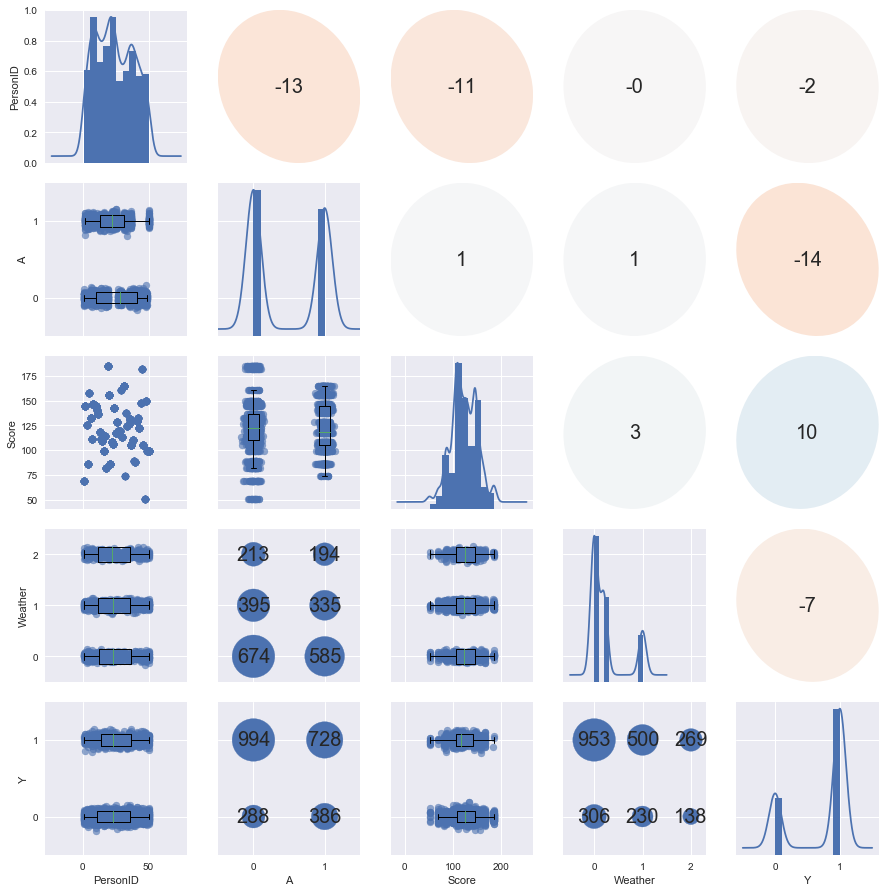

In [5]:
g = sns.PairGrid(df, diag_sharey=False)

d = Dispatcher()
# 対角成分
g.map_diag(d.diag)
# 下三角成分
g.map_lower(d.comb);
# 上三角成分
g.map_upper(d.ellipse);

## モデル式の記述

$q[i] = \beta_1 + \beta_2 A[i] + \beta_3 Score[i] + \beta_4 Weather[i] $

$Y[i]$ ~ $ Bernoulli( q[i] )$

$i = 1,...,I$

## Stanでの実装

In [6]:
model_code="""
data {
  int I;
  int<lower=0, upper=1> A[I];
  real<lower=0, upper=1> Score[I];
  real<lower=0, upper=1> Weather[I];
  int<lower=0, upper=1> Y[I];
}
parameters {
  real b1;
  real b2;
  real b3;
  real b4;
}
transformed parameters {
  real q[I];
  for (i in 1:I)
    q[i] = inv_logit(b1 + b2*A[i] + b3*Score[i] + b4*Weather[i]);
}
model {
  for (i in 1:I)
    Y[i] ~ bernoulli(q[i]);
}
"""

from pystan import StanModel
data = dict(I=df.shape[0], A=df.A, Score=df.Score/200, Weather=df.Weather, Y=df.Y)
sm = StanModel(model_code=model_code)

fit = sm.sampling(data=data, n_jobs=1, seed=123)
#fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4c8c2fab2607cea958e8ca7c5e5cec84 NOW.


## traceplot

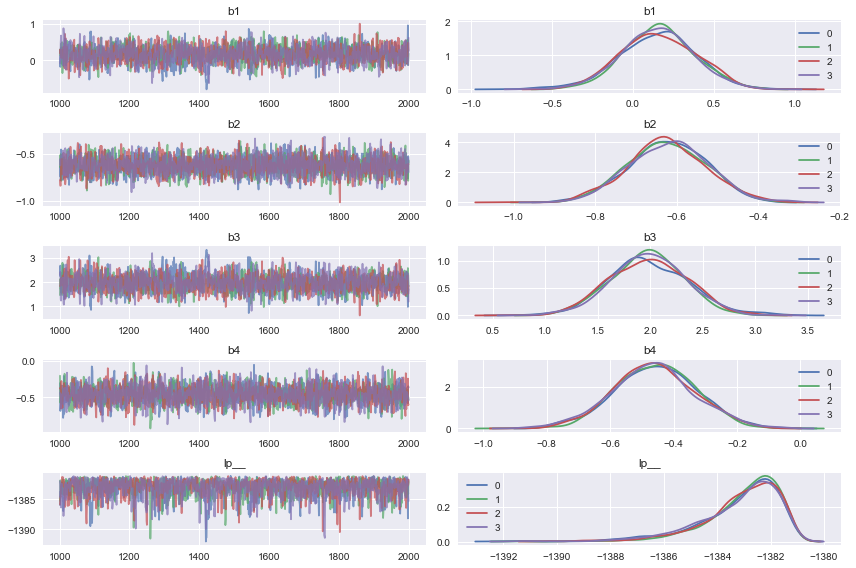

In [7]:
import math

palette = sns.color_palette()
ms = fit.extract(permuted=False, inc_warmup=True)
iter_from = fit.sim['warmup']
iter_range = np.arange(iter_from, ms.shape[0])
paraname = fit.sim['fnames_oi'][:4]
paraname.append(fit.sim['fnames_oi'][-1]) # 'lp__' もtrace plot に追加
paraname_key = [fit.sim['fnames_oi'].index(paran) for paran in paraname]

gpp = 5 # 画像１枚あたりの縦方向のグラフ数 gpp:graph per page
num_pages = math.ceil(len(paraname)/gpp)  # parameter 数をgppで割った数より大きい最少の整数=画像枚数

for pg in range(num_pages):  # 1ページにgppx2のグラフをプロットする
    plt.figure(figsize=(12,8))
    for pos in range(gpp):
        pi = pg*gpp + pos
        if pi >= len(paraname): break
        # trace plot
        plt.subplot(gpp, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,paraname_key[pi]], color=palette[ci], label=ci, alpha=.7) for ci in range(ms.shape[1])]
        
        plt.title(paraname[pi])
        # posterior distribution 
        plt.subplot(gpp, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,paraname_key[pi]], color=palette[ci], label=ci) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.legend()

# 図によるモデルのチェック(p73)
## 信頼区間データの作成

In [8]:
ms = fit.extract()

qua = np.percentile(ms['q'], q=[20, 50, 80], axis=0)
d_qua = pd.DataFrame(qua.T, 
                     columns=['p'+str(p) for p in [20, 50, 80]])
df_pred = df.join(d_qua)
df_pred.head()

,PersonID,A,Score,Weather,Y,p20,p50,p80
0,1,0,69,0.2,1,0.658698,0.678664,0.698345
1,1,0,69,0.0,1,0.678081,0.698275,0.718620
2,1,0,69,1.0,1,0.562908,0.593374,0.624369
3,1,0,69,0.0,1,0.678081,0.698275,0.718620
4,1,0,69,0.2,1,0.658698,0.678664,0.698345


## 応答変数のデータYと信頼区間

C:\Users\eX\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


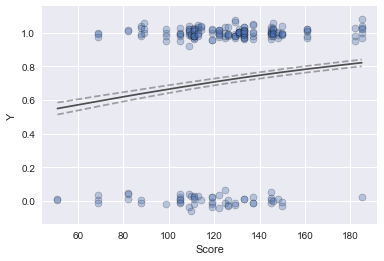

In [9]:
# A=0, Weather=1のデータに限定して作図
df_sub = df_pred[(df_pred["A"]==0) & (df_pred["Weather"]==1)]
df_sub.sort_values(by="Score", inplace=True)
# 実測値と予測値の散布図
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
jit = np.random.normal(0,0.025,len(df_sub))
ax.scatter(df_sub.Score, df_sub.Y+jit, alpha=1/3, linewidths=0.5, edgecolors='k')
ax.plot(df_sub.Score, df_sub.p80, 'k--', alpha=1/3)
ax.plot(df_sub.Score, df_sub.p50, 'k-', alpha=2/3)
ax.plot(df_sub.Score, df_sub.p20, 'k--', alpha=1/3)
ax.set_xlabel('Score')
ax.set_ylabel('Y')
plt.show()

## 確率と実測値のプロット

C:\Users\eX\Anaconda3\lib\site-packages\seaborn\categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)


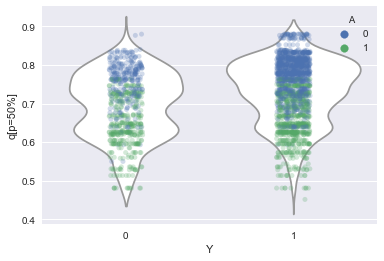

In [32]:
fig = plt.figure()

ax = fig.add_subplot(111)
sns.stripplot(x=df_pred.Y, y=df_pred.p50, jitter=True, hue=df_pred.A, alpha=1/4)
sns.violinplot(x=df_pred.Y, y=df_pred.p50, alpha=1/4, inner=None, color="white")
plt.ylabel("q[p=50%]")
plt.show()

## ROC曲線

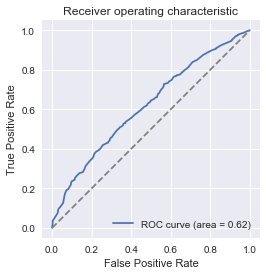

In [41]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true=df_pred.Y, y_score=df_pred.p50)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.axis('square')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## MCMC の散布図行列

In [43]:
df_mcmc = pd.DataFrame({'b1':ms['b1'], 
                      'b2':ms['b2'], 
                      'b3':ms['b3'],
                      'b4':ms['b4'],
                      'q1':ms['q'][:,1],
                      'lp__':ms['lp__']},
                      columns=['b1','b2','b3','b4', 'q1', 'lp__'])

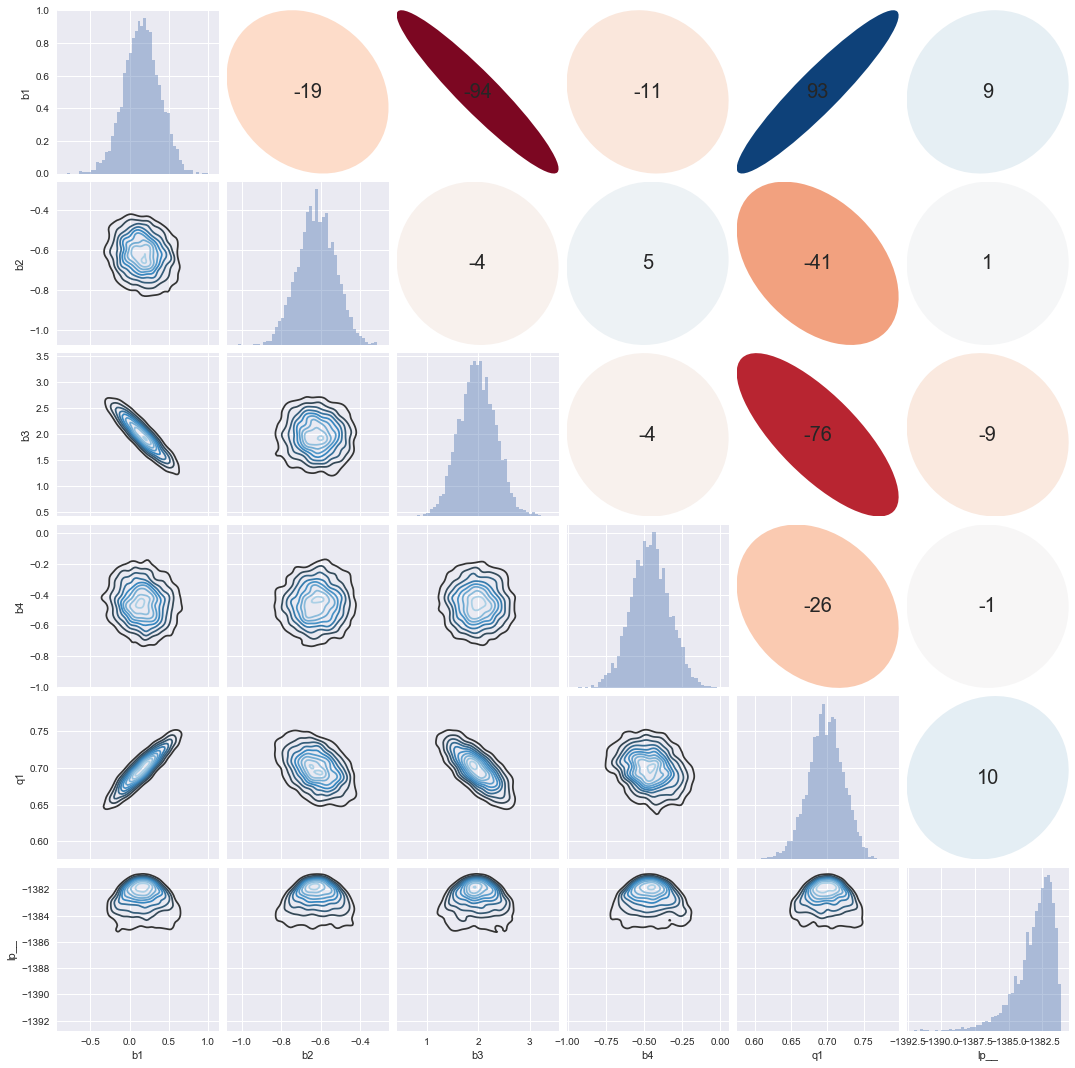

In [44]:
sns.set(font_scale=1)
g = sns.PairGrid(df_mcmc, diag_sharey=False)
d = Dispatcher()
# 対角成分
g.map_diag(sns.distplot, kde=False)
# 下三角成分
g.map_lower(sns.kdeplot, cmap='Blues_d');
# 上三角成分
g.map_upper(d.ellipse);

g.fig.subplots_adjust(wspace=0.05, hspace=0.05)